### This is a test for adding padding and new DFT lengths


In [1]:
import numpy as np
from scipy.signal import chirp, spectrogram
import simpleaudio as sa
from scipy.io.wavfile import write, read
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
from transmitter import *
from reciever import *
import random

In [2]:
fs = 44100
class OFDM:
    pass
ofdm = OFDM()
ofdm.N = 2048                   # Length of DTF
ofdm.start_bin = 50
ofdm.end_bin = 788
ofdm.CP = 256                      
ofdm.sfp = 20                   # Symbols per frame

ofdm.num_tones = 21              # Number of pilot tones
ofdm.pilot_locs = np.int64(np.linspace(49,789,ofdm.num_tones))     # Pilot locations
ofdm.pilot_vals = np.array([1+1j]*21)

ofdm.bps = 2                    # bits per symbol QFSK
ofdm.spb = 720                  # data symbols per block
ofdm.preamb = ofdm.N//2
ofdm.QFSK_dict = {              # The constellation
    (1,1) : -1-1j,
    (1,0) :  1-1j,
    (0,0) :  1+1j,
    (0,1) : -1+1j}


ofdm.rate = "1/2"
ofdm.z = 81

ofdm.pilot_locs

array([ 49,  86, 123, 160, 197, 234, 271, 308, 345, 382, 419, 456, 493,
       530, 567, 604, 641, 678, 715, 752, 789])

In [3]:
def addGuard(timeDomain, ofdm):
    print(ofdm.CP)
    return np.hstack((timeDomain[:,-ofdm.CP:], timeDomain))

In [18]:
def fullTrans(data, ofdm):

    # ldpc implementation
    ldpc = LDPC(rate = ofdm.rate, z = ofdm.z)
    ldpc_ified = ldpc.encode(data)
    
    symb = bit2symbol(ldpc_ified, ofdm)

    cut_symb = cut2Blocks(symb, ofdm)
    # syb_padded = addpadding(cut_symb, ofdm)
    all_symbs = goodSymbols(cut_symb,ofdm)

    tds = ifft(all_symbs, 2048)
    return addGuard(tds, ofdm)

In [3]:
        ### Data forming With image
bit_array = bitsFromTiff('jaguar.tiff')

        ### Data from text
#bit_array = 
print('Length of bits', len(bit_array)/8)

payload = fullTrans(bit_array, ofdm)


Length of bits 26800.0
256


In [7]:
from transmitter import LDPC
import numpy as np

code = LDPC(ofdm.rate, ofdm.z)

encoded = code.encode(bit_array)
y = 10*(.5-encoded)

app = code.decode(y)

array([-5., -5., -5.,  5.,  5.,  5., -5., -5., -5., -5., -5.,  5., -5.,
        5.,  5., -5., -5., -5., -5.,  5., -5., -5., -5., -5., -5., -5.,
       -5., -5., -5., -5., -5., -5., -5., -5., -5.,  5.,  5., -5.,  5.,
        5., -5., -5., -5.,  5., -5.,  5.,  5., -5., -5., -5., -5.,  5.,
       -5., -5., -5.,  5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
       -5., -5.,  5.,  5., -5.,  5.,  5., -5., -5., -5.,  5., -5.,  5.,
        5., -5., -5., -5., -5.,  5., -5., -5., -5.,  5., -5., -5., -5.,
       -5., -5., -5., -5., -5., -5., -5., -5.,  5.,  5., -5.,  5.,  5.,
       -5., -5., -5.,  5., -5.,  5.,  5., -5., -5., -5., -5.,  5., -5.,
       -5.,  5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
       -5.,  5.,  5., -5.,  5.,  5., -5., -5., -5.,  5., -5.,  5.,  5.,
       -5., -5., -5., -5.,  5., -5., -5.,  5., -5., -5., -5., -5., -5.,
       -5., -5., -5., -5., -5., -5., -5.,  5.,  5., -5.,  5.,  5., -5.,
       -5., -5.,  5., -5.,  5.,  5., -5., -5., -5., -5.,  5., -5

In [4]:
import ldpc_jossy.py.ldpc as ldpc

c = ldpc.code(rate = ofdm.rate, z = ofdm.z, standard = "802.11n")
print(c.K)

x = np.random.randint(0,2,c.K)
print(x.shape)
print(x[:20])

encoded = c.encode(x)
print(encoded[:20])

decoded, it = c.decode(10 * (0.5 - encoded), dectype = "sumprod2")
decoded[:20]

972
(972,)
[0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1]
[0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1]


array([ 5., -5., -5.,  5., -5., -5.,  5.,  5.,  5.,  5., -5., -5.,  5.,
       -5.,  5.,  5.,  5.,  5.,  5., -5.])

In [7]:
c.Nv

1944

In [8]:
def standard_deconstructor(aud, ofdm, channel_H = None, retSymbs = False):
    N = ofdm.N
    L = ofdm.CP
    QFSK_dict  = ofdm.QFSK_dict
    backwards_dict = {v : k for k, v in QFSK_dict.items()}

    bits_organised = aud.reshape((-1, L+N))

    cut_bits = bits_organised[:,L:]

    freq_data = fft(cut_bits)

    # symbols = freq_data[:,1:int(N/2)]

    # equalisation

    if channel_H is None:
        pass
    else:
        freq_data = freq_data / channel_H

    symbols = extractor(freq_data, ofdm)
    print(symbols.shape)

    soliddata=[]
    for i in symbols:
        for j in i:
            if j.real > 0 and j.imag > 0:
                soliddata.extend([backwards_dict[1+1j][0],backwards_dict[1+1j][1]])
            elif j.real < 0 and j.imag > 0:
                soliddata.extend([backwards_dict[-1+1j][0],backwards_dict[-1+1j][1]])
            elif j.real > 0 and j.imag < 0:
                soliddata.extend([backwards_dict[1-1j][0],backwards_dict[1-1j][1]])
            else:
                soliddata.extend([backwards_dict[-1-1j][0],backwards_dict[-1-1j][1]])

    coder = LDPC(rate = ofdm.rate, z = ofdm.z)
    print(np.array(soliddata).shape)
    decoded = coder.decode(np.array(soliddata))
    
    if retSymbs == True:
        return np.array(decoded), symbols
    else:
        return np.array(decoded)

Length of bits 26800.0
256
(299, 2304)
(299, 720)


/Users/metehergul/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(430560,)


ValueError: cannot reshape array of size 430560 into shape (1944)

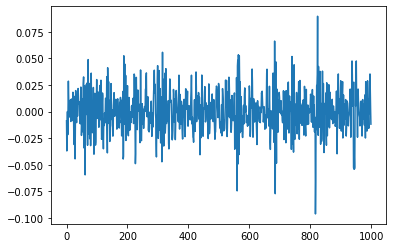

In [9]:
        ### Data forming With image
bit_array = bitsFromTiff('jaguar.tiff')

        ### Data from text
#bit_array = 
print('Length of bits', len(bit_array)/8)

payload = fullTrans(bit_array, ofdm)

print(payload.shape)


plt.plot(payload.flatten()[50000:51000])
x = standard_deconstructor(payload.flatten(), ofdm, channel_H = None, retSymbs = False)
print(x.shape)
bitsToSaveImage(x[:214400], 'trialpayload', 67, 100)

In [3]:
        ### Data forming With image
bit_array = bitsFromTiff('jaguar.tiff')

        ### Data from text
#bit_array = 
print('Length of bits', len(bit_array)/8)

zeros = np.zeros(bit_array.shape)


payload = fullTrans(zeros, ofdm)
#flat_payload = payload.flatten() / np.max(np.abs(payload.flatten()))
print("payload shape:",np.shape(payload))

""" 

# pilot_symbs = goodSymbols(payload, ofdm)
pilot_full = addGuard(inversedft(pilot_symbs), ofdm)
pilot_full = pilot_full.flatten() / np.max(np.abs(pilot_full.flatten()))


### Chirp makeing for sync
chirp_time = 5*(ofdm.N+ofdm.CP) / fs
t = np.linspace(0, chirp_time, int(chirp_time * fs), False)
note = chirp(t, f0=500, f1=15000, t1=chirp_time, method='linear')
chirp_symbol = note / np.max(np.abs(note)) """

Length of bits 26800.0


AttributeError: 'numpy.ndarray' object has no attribute 'bps'

In [57]:
payload.shape

(149, 2304)

In [41]:
def extractor(symbols, ofdm):
    indices = [i for i in range(ofdm.pilot_locs[0], ofdm.pilot_locs[-1]) if i not in ofdm.pilot_locs]
    return symbols[:,indices]


def standard_deconstructor(aud, ofdm, channel_H = None, retSymbs = False):
    N = ofdm.N
    L = ofdm.CP
    QFSK_dict  = ofdm.QFSK_dict
    backwards_dict = {v : k for k, v in QFSK_dict.items()}

    bits_organised = aud.reshape((-1, L+N))

    cut_bits = bits_organised[:,L:]

    freq_data = fft(cut_bits)

    # symbols = freq_data[:,1:int(N/2)]

    # equalisation

    if channel_H is None:
        pass
    else:
        freq_data = freq_data / channel_H

    symbols = extractor(freq_data, ofdm)

    soliddata=[]
    for i in symbols:
        for j in i:
            if j.real > 0 and j.imag > 0:
                soliddata.extend([backwards_dict[1+1j][0],backwards_dict[1+1j][1]])
            elif j.real < 0 and j.imag > 0:
                soliddata.extend([backwards_dict[-1+1j][0],backwards_dict[-1+1j][1]])
            elif j.real > 0 and j.imag < 0:
                soliddata.extend([backwards_dict[1-1j][0],backwards_dict[1-1j][1]])
            else:
                soliddata.extend([backwards_dict[-1-1j][0],backwards_dict[-1-1j][1]])

    if retSymbs == True:
        return np.array(soliddata), symbols
    else:
        return np.array(soliddata)

/Users/metehergul/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


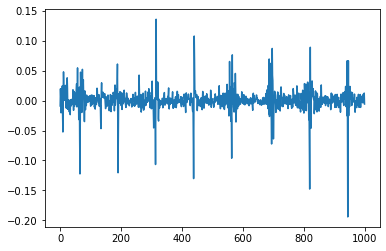

In [44]:
plt.plot(payload.flatten()[50000:51000])
x = standard_deconstructor(payload.flatten(), ofdm, channel_H = None, retSymbs = False)
bitsToSaveImage(x[:214400], 'trialpayload', 67, 100)

In [5]:
emtpy = np.zeros(ofdm.N)

frame = frameMaker(chirp_symbol, pilot_full, payload, ofdm.ofdmSymbolsPerFrame, zeros_post_sync=emtpy, zeros_post_sybm=emtpy)
print("Frame Shape:",np.shape(frame))
audio_for_file = audioMaker(frame, 'multiframetest1', fs)

print("audio file length (samples, seconds):",len(audio_for_file), len(audio_for_file)*1/fs)

NameError: name 'chirp_symbol' is not defined

In [6]:
plt.figure(figsize = (30, 10))
plt.plot(audio_for_file[7500:12000])
print('Length of audio:',len(audio_for_file))
print('Expected length of audio:', (len(payload[0:5].flatten())+len(chirp_symbol)+len(emtpy)*2+len(pilot_full)))
print('Expected length of audio:', len(payload.flatten())+len(chirp_symbol)*42+len(emtpy)*42*2)

NameError: name 'audio_for_file' is not defined

<Figure size 2160x720 with 0 Axes>

In [7]:
record(18,fs,'big_frame_image') 

KeyboardInterrupt: 

In [26]:
Fs, aud = read('big_frame_image.wav')

powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(aud, Fs=fs)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'big_frame_image.wav'

In [ ]:
plt.plot(np.correlate(aud, chirp_symbol, mode='full')[109200:109400])

In [9]:
x = bitsFromTxt('jabberwocky.txt')
# bitsFromTiff('jaguar.tiff')

bitArrayToText(x)

'Twas brillig, and the slithy toves
Did gyre and gimble in the wabe:
All mimsy were the borogoves,
And the mome raths outgrabe.

"Beware the Jabberwock, my son!
The jaws that bite, the claws that catch!
Beware the Jubjub bird, and shun
The frumious Bandersnatch!"

He took his vorpal sword in hand;
Long time the manxome foe he sought-
So rested he by the Tumtum tree
And stood awhile in thought.

And, as in uffish thought he stood,
The Jabberwock, with eyes of flame,
Came whiffling through the tulgey wood,
And burbled as it came!

One, two! One, two! And through and through
The vorpal blade went snicker-snack!
He left it dead, and with its head
He went galumphing back.

"And hast thou slain the Jabberwock?
Come to my arms, my beamish boy!
O frabjous day! Callooh! Callay!"
He chortled in his joy.

'Twas brillig, and the slithy toves
Did gyre and gimble in the wabe:
All mimsy were the borogoves,
And the mome raths outgrabe.


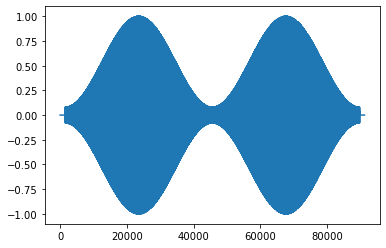

In [4]:
plt.plot(double_chirp())

In [4]:
ofdm.pilot_locs

array([ 49,  86, 123, 160, 197, 234, 271, 308, 345, 382, 419, 456, 493,
       530, 567, 604, 641, 678, 715, 752, 789])

In [5]:
import scipy

In [6]:
pilot_test = addpilots(np.zeros(720), ofdm)

scipy.signal.find_peaks(pilot_test)

/Users/metehergul/opt/anaconda3/lib/python3.8/site-packages/scipy/signal/_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


(array([ 48,  85, 122, 159, 196, 233, 270, 307, 344, 381, 418, 455, 492,
        529, 566, 603, 640, 677, 714, 751, 788]),
 {})

In [7]:
gs = goodSymbols([np.zeros(720)], ofdm)[0]

print(gs[:100])
# goodSymbols fucks things up here.

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+1.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+1.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [8]:
tds = ifft(gs, 2048)
tds.shape

(2048,)

/Users/metehergul/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


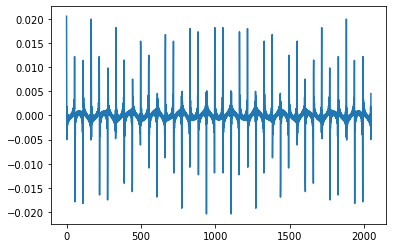

In [9]:
plt.plot(tds)

/Users/metehergul/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


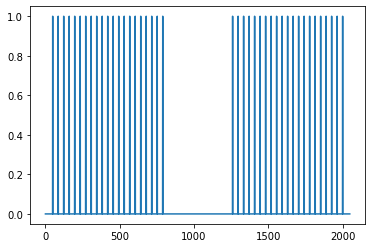

In [11]:
fds = fft(tds, int(2048))
plt.plot(fds)

array([ 0.-0.j,  0.-0.j,  0.-0.j,  0.-0.j,  0.-0.j, -0.-0.j, -0.-0.j,
       -0.+0.j,  0.-0.j, -0.-0.j,  0.+0.j,  0.-0.j,  0.-0.j,  0.-0.j,
        0.-0.j,  0.-0.j,  1.+1.j, -0.+0.j,  0.+0.j, -0.-0.j,  0.+0.j,
        0.-0.j,  0.+0.j, -0.+0.j,  0.-0.j])

In [24]:
# indices = [i for i in range(ofdm.pilot_locs[0], ofdm.pilot_locs[-1]) if i not in ofdm.pilot_locs]

In [25]:
def extractor(symbols, ofdm):
    indices = [i for i in range(ofdm.pilot_locs[0], ofdm.pilot_locs[-1]) if i not in ofdm.pilot_locs]
    return symbols[:,indices]

    

In [ ]:
def standard_deconstructor(aud, ofdm, numpy_func = True, channel_H = None, retSymbs = False):
    N = ofdm.N
    L = ofdm.CP
    QFSK_dict  = ofdm.QFSK_dict
    backwards_dict = {v : k for k, v in QFSK_dict.items()}

    bits_organised = aud.reshape((-1, L+N))

    cut_bits = bits_organised[:,L:]

    if numpy_func == True:
        freq_data = np.fft.fft(cut_bits)
    else:
        freq_data = fft(cut_bits)


    symbols = freq_data[:,1:int(N/2)]

    # equalisation

    if channel_H is None:
        pass
    else:
        symbols = symbols / channel_H

    symbols = extractor(symbols, ofdm)

    soliddata=[]
    for i in symbols:
        for j in i:
            if j.real > 0 and j.imag > 0:
                soliddata.extend([backwards_dict[1+1j][0],backwards_dict[1+1j][1]])
            elif j.real < 0 and j.imag > 0:
                soliddata.extend([backwards_dict[-1+1j][0],backwards_dict[-1+1j][1]])
            elif j.real > 0 and j.imag < 0:
                soliddata.extend([backwards_dict[1-1j][0],backwards_dict[1-1j][1]])
            else:
                soliddata.extend([backwards_dict[-1-1j][0],backwards_dict[-1-1j][1]])

    if retSymbs == True:
        return np.array(soliddata), symbols
    else:
        return np.array(soliddata)

In [3]:
import ldpc_jossy.py.ldpc as ldpc
import numpy as np

In [4]:
c = ldpc.code()
c.standard

'802.11n'

In [5]:
u = np.random.randint(0,2,c.K)
x = c.encode(u)

In [6]:
np.mod(np.matmul(x,np.transpose(c.pcmat())), 2)
y = 10*(.5-x)

In [8]:
app,it = c.decode(y)

In [39]:
class LDPC:
    def __init__(self, rate, z) -> None:
        self.rate = rate
        self.z = z
        self.coder = ldpc.code(rate = rate, z = z)

    def encode(self, bin_seq):
        Y = self.coder.pcmat().shape[0]
        remainder = Y - (len(bin_seq) % Y)
        coerced = np.concatenate((bin_seq, np.zeros(remainder)))
        coerced = coerced.reshape(-1, self.coder.pcmat().shape[0])
        return np.array([self.coder.encode(c) for c in coerced])

    def decode(self, bin_seq):
        recoerced = bin_seq.reshape(-1, self.coder.pcmat().shape[1])
        return self.coder.decode(bin_seq)

In [40]:
bin_seq = bitsFromTxt('jabberwocky.txt')

coder = LDPC(rate = "1/2", z = 81)

print(coder.coder.pcmat().shape)


ldpc_seq = coder.encode(bin_seq)

ldpc_seq.shape

(972, 1944)


(8, 1944)

In [33]:
remainder = 972 - (len(bin_seq) % 972)
coerced = np.concatenate((bin_seq, np.zeros(remainder)))
coerced = coerced.reshape(-1, coder.coder.pcmat().shape[0])